In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

In [11]:
df = pd.read_csv('dailydata.csv', index_col = 'date')
# df.index=pd.to_datetime(df.index, format='%d %m %Y')
# df.index.freq='D'

,views,date
0,264542787,2015-07-01T00:00:00Z
1,270340050,2015-07-02T00:00:00Z
2,253265588,2015-07-03T00:00:00Z
3,253088829,2015-07-04T00:00:00Z
4,266057125,2015-07-05T00:00:00Z
...,...,...
2402,316590066,2022-01-27T00:00:00Z
2403,318078314,2022-01-28T00:00:00Z
2404,325150175,2022-01-29T00:00:00Z
2405,343780904,2022-01-30T00:00:00Z


<AxesSubplot:xlabel='timestamp'>

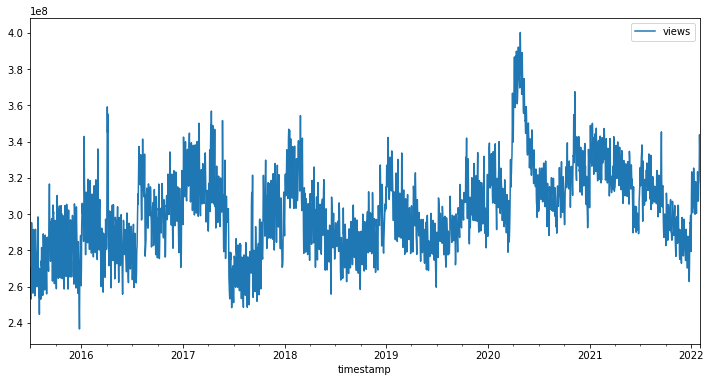

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

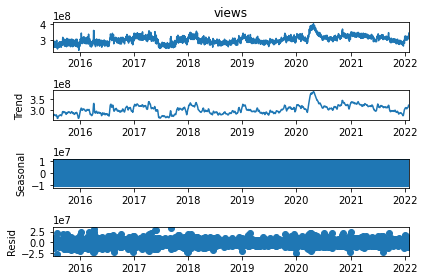

In [5]:
results = seasonal_decompose(df['views'])
results.plot();

In [6]:
train = df.iloc[:1925]
test = df.iloc[1925:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
scaled_train[:10]

array([[0.17099452],
       [0.20642882],
       [0.10206549],
       [0.10098509],
       [0.18025053],
       [0.35857731],
       [0.29513516],
       [0.29205691],
       [0.31367754],
       [0.22225202]])

  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)


ValueError: too many values to unpack (expected 2)

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
# define generator
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [12]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.17099452 0.20642882 0.10206549 0.10098509 0.18025053 0.35857731
 0.29513516]
Predict this y: 
 [[0.29205691]]


In [13]:
X.shape

(1, 7, 1)

In [ ]:
# We do the same thing, but now instead for 12 months
#n_input = 12
#generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [18]:
# define model
model = Sequential()
model.add(Dense(7, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(7, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7, 7)              14        
                                                                 
 lstm_1 (LSTM)               (None, 7)                 420       
                                                                 
 dense_3 (Dense)             (None, 7)                 56        
                                                                 
 dense_4 (Dense)             (None, 1)                 8         
                                                                 
Total params: 498
Trainable params: 498
Non-trainable params: 0
_________________________________________________________________


In [21]:
# fit model
model.fit(generator,epochs=30)

Epoch 1/30
1918/1918 [==============================] - 20s 10ms/step - loss: 0.0063
Epoch 2/30
1918/1918 [==============================] - 20s 10ms/step - loss: 0.0059
Epoch 3/30
1918/1918 [==============================] - 15s 8ms/step - loss: 0.0054
Epoch 4/30
1918/1918 [==============================] - 14s 8ms/step - loss: 0.0050
Epoch 5/30
1918/1918 [==============================] - 15s 8ms/step - loss: 0.0044
Epoch 6/30
1918/1918 [==============================] - 15s 8ms/step - loss: 0.0039
Epoch 7/30
1918/1918 [==============================] - 15s 8ms/step - loss: 0.0037
Epoch 8/30
1918/1918 [==============================] - 17s 9ms/step - loss: 0.0036
Epoch 9/30
1918/1918 [==============================] - 18s 10ms/step - loss: 0.0036
Epoch 10/30
1918/1918 [==============================] - 16s 8ms/step - loss: 0.0035
Epoch 11/30
1918/1918 [==============================] - 15s 8ms/step - loss: 0.0035
Epoch 12/30
1918/1918 [==============================] - 13s 7ms/step -

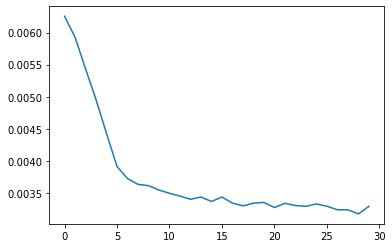

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-7:]

In [25]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [26]:
model.predict(last_train_batch)

array([[0.46146238]], dtype=float32)

In [27]:
scaled_test[0]

array([0.54675473])

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [51]:
test_predictions

[array([0.45458883], dtype=float32),
 array([0.38486767], dtype=float32),
 array([0.33388418], dtype=float32),
 array([0.3160514], dtype=float32),
 array([0.3837431], dtype=float32),
 array([0.4541524], dtype=float32),
 array([0.41977262], dtype=float32),
 array([0.38226587], dtype=float32),
 array([0.34691036], dtype=float32),
 array([0.28676468], dtype=float32),
 array([0.2571472], dtype=float32),
 array([0.33841032], dtype=float32),
 array([0.4169559], dtype=float32),
 array([0.3761323], dtype=float32),
 array([0.33907974], dtype=float32),
 array([0.3042302], dtype=float32),
 array([0.24337372], dtype=float32),
 array([0.20265777], dtype=float32),
 array([0.29136962], dtype=float32),
 array([0.36646497], dtype=float32),
 array([0.3243544], dtype=float32),
 array([0.28950232], dtype=float32),
 array([0.25560558], dtype=float32),
 array([0.2009278], dtype=float32),
 array([0.16096833], dtype=float32),
 array([0.24544185], dtype=float32),
 array([0.3136139], dtype=float32),
 array([0.2

In [55]:
test.head()

,views,Predictions
timestamp,,
2020-10-07,326019390,3.109405e+08
2020-10-08,322445182,2.995337e+08
2020-10-09,314556187,2.911925e+08
2020-10-10,314649225,2.882750e+08
2020-10-11,327725466,2.993497e+08


In [29]:
true_predictions = scaler.inverse_transform(test_predictions)

In [30]:
test['Predictions'] = true_predictions

C:\Users\Bangkit\AppData\Local\Temp/ipykernel_11532/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='timestamp'>

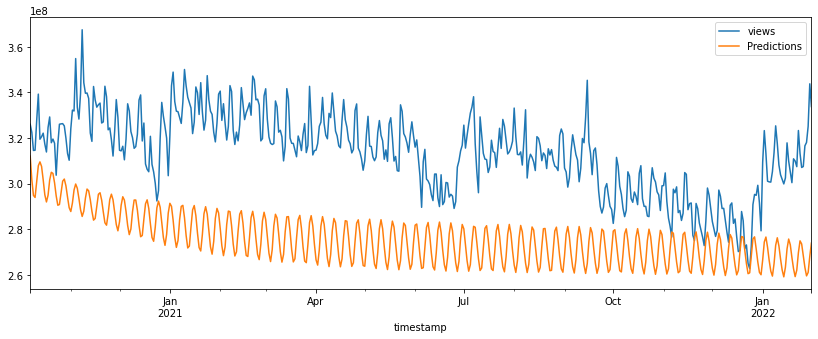

In [31]:
test.plot(figsize=(14,5))

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['views'],test['Predictions']))
print(rmse)

41149770.812196694
